In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [ ]:
from sklearn.tree import DecisionTreeClassifier

titanic set 을 이용해서, pclass / age / sex 가 과연 생존에 어떤 영향을 끼치는지 알아보자

# 데이터 전처리

 - Scikit-learn에서 제공하는 Decision Tree model은 문자열(String) 형태의 변수가 있을 경우 실행 시 오류가 발생한다.<br>
 - 또한 범주형 변수임을 지정해주는 Parmater도 없기 때문에 범주형 변수들을 전부 가변수 처리를 해줘야 한다

## 데이터 살펴보기

In [94]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [95]:
# string 이 있는지 검사
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In [99]:
# 곁측치가 있는지 검사
df.isnull().sum(axis=0)

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

## X data set 만들기

In [162]:
dfX = df[["pclass", "age", "sex"]].copy()
dfX.head()

,pclass,age,sex
0,3,22.0,male
1,1,38.0,female
2,3,26.0,female
3,1,35.0,female
4,3,35.0,male


In [163]:
# label Encoder 로 범주형 변수를 정수값으로 바꾸기
from sklearn.preprocessing import LabelEncoder
dfX["sex"] = LabelEncoder().fit_transform(dfX["sex"])
dfX.head()

,pclass,age,sex
0,3,22.0,1
1,1,38.0,0
2,3,26.0,0
3,1,35.0,0
4,3,35.0,1


In [87]:
# age 의 곁측치를 평균으로 치환하기
dfX["age"].fillna(dfX["age"].mean(), inplace=True)
dfX.head()

,pclass,age,sex
0,3,22.0,1
1,1,38.0,0
2,3,26.0,0
3,1,35.0,0
4,3,35.0,1


In [88]:
# 0,1,2 로 표현된 pclass 를 dummy variable 들로 변환
pclass_dummy=pd.get_dummies(dfX['pclass'])
pclass_dummy.columns = ['c1','c2','c3']
dfX=pd.concat([dfX,pclass_dummy],axis=1)
dfX.drop('pclass',axis=1,inplace=True)
dfX.head()

,age,sex,c1,c2,c3
0,22.0,1,0,0,1
1,38.0,0,1,0,0
2,26.0,0,0,0,1
3,35.0,0,1,0,0
4,35.0,1,0,0,1


## y data set 만들기

In [138]:
dfy = df["survived"].copy()

# model fitting 하기

In [145]:
# train/ test set 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.25, random_state=0)

In [146]:
#model 만들고, X_train/ Y_train 에 fitting 하기
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5).fit(X_train, y_train)
# criterion : 불순성의 기준을 뭐로 할지 'gini'(defalut) / 'entropy'
# 다음의 parameterm 들으 overfitting 을 해결해준다.
# max_depth : 트리의 최대 깊이. 
#           : (defalut) full tree 가 될때까지 확장.
#           : 이를 이용해 사전 가지치기를 하고/ overfitting 을 해결할 수 있다.
# min_samples_split : 노드에서 가지 분리할 떄 필요한 최소 sample 갯수에 제한을 준다.
#                   : (default) = 2 
# min_samples_leaf : leaf 에서 가져야 할 최소 sample 
#                  : (default) = 1
# max_features : Decision tree 를 만들때 사용할 수 있는 변수의 갯수 제한
#              : (default) = 총 변수 갯수 사용

## 다른방법

In [148]:
#model fitting 할 때에 train/test 를 나누지 않고 바로 k-fold 로 해버리는 방법도 있다.
#이 방법은 k-fold 여서, 시각화하기가 어렵다.(각각 sample 마다 트리가 다를것 이므로)

#k=fold 방법
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(5, shuffle=True, random_state=0)
model1 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
cross_val_score(model1, dfX, dfy, scoring="accuracy", cv=cv).mean()

0.7845081915761722

# model 평가하기

In [149]:
#confusion matrix
from sklearn.metrics import confusion_matrix

display(
confusion_matrix(y_train, model.predict(X_train)),
confusion_matrix(y_test, model.predict(X_test)))

array([[360,  50],
       [ 73, 185]], dtype=int64)

array([[119,  20],
       [ 25,  59]], dtype=int64)

In [150]:
# 총체적인 성적표
from sklearn.metrics import classification_report
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       410
           1       0.79      0.72      0.75       258

    accuracy                           0.82       668
   macro avg       0.81      0.80      0.80       668
weighted avg       0.81      0.82      0.81       668



In [158]:
#decision tree 의 시각화. 어떻게 분류햇는가?
import io
import pydot
from IPython.core.display import Image
from sklearn.tree import export_graphviz

#X 의 feature name 저장하기 (시각화를 위함)
feature_names = dfX.columns 

def draw_decision_tree(model):
    dot_buf = io.StringIO()
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0]
    image = graph.create_png()
    return Image(image)

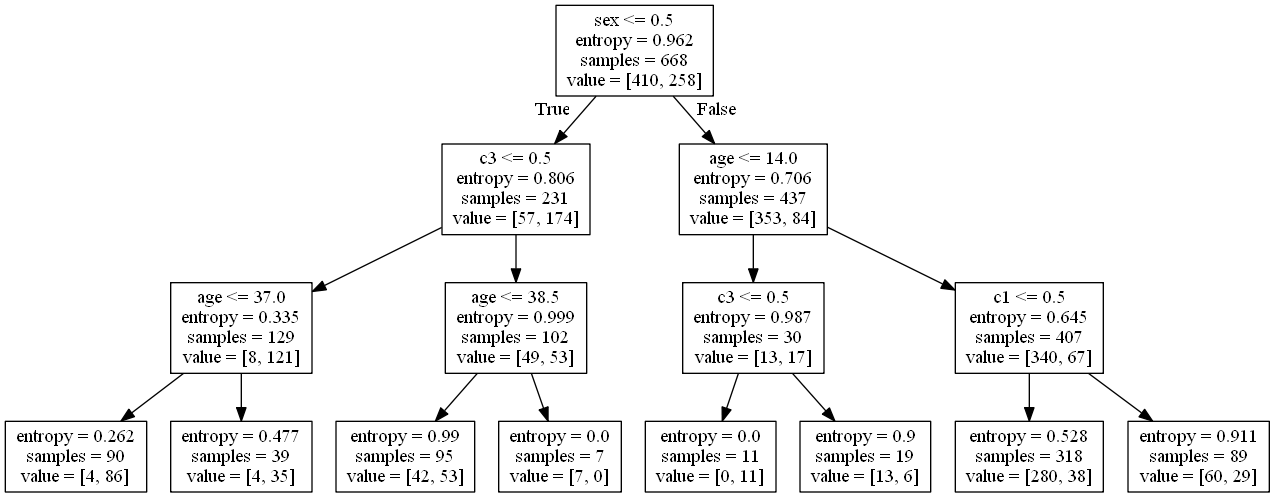

In [159]:
draw_decision_tree(model)

# 예측 및 해석

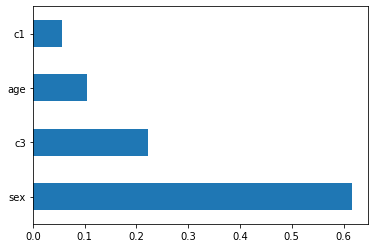

In [160]:
feat_importances = pd.Series(model.feature_importances_, index=dfX.columns)
feat_importances.nlargest(4).plot(kind='barh')

생존에 제일 중요했던 변수는 성별이였다

In [164]:
#X = ['age', 'sex', 'c1', 'c2', 'c3'] 임을 상기하자.
#Y = [die,survive]
model.predict_proba([[8,0,1,0,0]]) 
# 8살 여자 승객클래스가 고급 이면 살 확률이 95%나 된다. 

array([[0.04444444, 0.95555556]])